Epoch [1/5], Step [100/600], Loss: 0.5522
Epoch [1/5], Step [200/600], Loss: 0.3971
Epoch [1/5], Step [300/600], Loss: 0.2643
Epoch [1/5], Step [400/600], Loss: 0.2066
Epoch [1/5], Step [500/600], Loss: 0.2108
Epoch [1/5], Step [600/600], Loss: 0.1594
Epoch [2/5], Step [100/600], Loss: 0.2081
Epoch [2/5], Step [200/600], Loss: 0.2130
Epoch [2/5], Step [300/600], Loss: 0.1598
Epoch [2/5], Step [400/600], Loss: 0.1836
Epoch [2/5], Step [500/600], Loss: 0.1121
Epoch [2/5], Step [600/600], Loss: 0.0776
Epoch [3/5], Step [100/600], Loss: 0.1044
Epoch [3/5], Step [200/600], Loss: 0.2028
Epoch [3/5], Step [300/600], Loss: 0.0557
Epoch [3/5], Step [400/600], Loss: 0.0925
Epoch [3/5], Step [500/600], Loss: 0.3301
Epoch [3/5], Step [600/600], Loss: 0.0456
Epoch [4/5], Step [100/600], Loss: 0.1443
Epoch [4/5], Step [200/600], Loss: 0.1383
Epoch [4/5], Step [300/600], Loss: 0.1181
Epoch [4/5], Step [400/600], Loss: 0.0440
Epoch [4/5], Step [500/600], Loss: 0.1462
Epoch [4/5], Step [600/600], Loss:

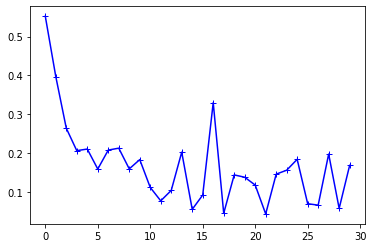

0.1689525030553341
tensor(1.)
torch.Size([100, 784])
sample size: torch.Size([100, 784])
relu Size: torch.Size([47, 100])
Average Active Neurons = 43.76
sparsity 0.06893617021276599
Accuracy of the network on the 10000 test images: 96.87 %


In [89]:
#test if relu after maxpooling is likely to get linear. --didn't see it so far.  
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import time

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784
# hidden_size = 800
hidden_size = 100
num_classes = 10
batch_size = 100
learning_rate = 0.001
num_workers=0

num_epochs = 5

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='/Users/dongcui/github/visualising-cnns/data', train=True,
                                   download=False, transform=transform)
test_data = datasets.MNIST(root='/Users/dongcui/github/visualising-cnns/data', train=False,
                                  download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle = True)

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size) 
#         self.maxpool=nn.MaxPool1d(2, 1)
#         self.maxpool=nn.MaxPool1d(4, 1)
#         self.maxpool=nn.MaxPool1d(4, 2)
        self.maxpool=nn.MaxPool1d(8, 2)
        self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size - 3, num_classes)  #-n because of pooling
        self.fc2 = nn.Linear(47, num_classes)
    
    def forward(self, x):
        out = x
#         print('self.fc1(out).shape=', self.fc1(out).shape)
        out = self.maxpool(self.fc1(out).unsqueeze(1))
#         print("out.shape=", out.shape)
#         print('out.squeeze(1).shape', out.squeeze().shape)
        out_relu = self.relu(out.squeeze())
#         print('out_relu.shape', out_relu.shape)
        out = self.fc2(out_relu)
        return out, out_relu   

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

#test
# A = torch.randn(2,4)#2 is data size, 4 is feature input size
# print(A)
# A = A.unsqueeze_(0)
# print(A.shape)
# print(model.maxpool(A))




#visualzing graphs
# writer=SummaryWriter('runs/experiment_1')
# dataiter=iter(train_loader)
# images, labels = dataiter.next()
# # print(images.shape)
# grid = torchvision.utils.make_grid(images)
# #writer.add_image('images', grid, 0)

# #images = images.reshape(-1, 28*28).to(device)
# dummy_input = torch.zeros(1, 28*28),
# writer.add_graph(model, dummy_input)
# writer.close()


start = time.time()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
losses=[]
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs, _  = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            losses.append(loss.item())
            

print('elapsed: ', time.time()-start)
plt.plot(losses, '-b+')
plt.show()
print(np.mean(losses))

#check dead neurons
dataiter=iter(train_loader)
images, labels = dataiter.next()
images = images.reshape(-1, 28*28).to(device)
print(torch.max(images[0]))#pixels are normalized

print(images.shape)
A1 = images[:100]
print("sample size:", A1.shape)
output, output_relu = model(A1)

output_relu = output_relu.T.detach()
print("relu Size:", output_relu.shape)# interesting, data size is in second dimension. 
# plt.plot(output_relu.numpy(), '-b+')
# plt.show()
print('Average Active Neurons =', np.count_nonzero(output_relu)/A1.shape[0])
print('sparsity', 1- np.count_nonzero(output_relu)/ (output_relu.shape[0] * output_relu.shape[1]))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
labels_wrong = []
pred_wrong = []
img_wrong = []
with torch.no_grad():
    correct = 0
    total = 0
    for img, labels in test_loader:
#         print(img.shape)
        images = img.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        wrong_preds = (predicted != labels).numpy()
        wrong_index = []
        for (i, wrong) in enumerate(wrong_preds):
            if wrong:
                wrong_index.append(i) 
        if len(wrong_index) > 0:
            img_reshaped = img[wrong_index].numpy()[:,0,:,:]
            for img_w in range(img_reshaped.shape[0]):
                img_wrong.append(img_reshaped[img_w])
            labels_wrong  += (labels[wrong_index].numpy().tolist())
            pred_wrong += (predicted[wrong_index].numpy().tolist())
#     print(img_wrong)
#     print('img_wrong.shape', img_wrong[0].shape)
#     print('lables_wrong =', labels_wrong)
#     print('predictions wrong are:', pred_wrong)
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

#show wrong images:
# print(len(img_wrong), ', ', len(labels_wrong), ', ', len(pred_wrong))
# for i in range(len(img_wrong)):
#     plt.imshow(img_wrong[i])
#     print('labels_wrong[i]:', labels_wrong[i])
#     print('pred_wrong[i]', pred_wrong[i])
#     plt.pause(1)

# Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')

In [72]:
print('Average Active Neurons =', np.count_nonzero(output_relu)/output_relu.shape[0])

print('layer 1:')
w_fc1 = list(model.fc1.parameters())
print(w_fc1)

print('layer 2:')
w_fc2 = list(model.fc2.parameters())
print(w_fc2)

Average Active Neurons = 37.462
layer 1:
[Parameter containing:
tensor([[ 0.0130, -0.0188, -0.0024,  ..., -0.0205, -0.0091, -0.0043],
        [ 0.0033, -0.0016,  0.0280,  ..., -0.0147, -0.0031,  0.0006],
        [ 0.0079,  0.0102,  0.0261,  ..., -0.0042, -0.0020, -0.0068],
        ...,
        [-0.0171,  0.0092,  0.0084,  ...,  0.0206,  0.0248,  0.0227],
        [ 0.0295,  0.0247,  0.0058,  ..., -0.0149,  0.0173, -0.0035],
        [ 0.0348,  0.0101,  0.0070,  ...,  0.0008,  0.0263, -0.0051]],
       requires_grad=True), Parameter containing:
tensor([ 4.5606e-02, -8.7214e-03,  6.5915e-02, -2.7034e-02,  4.6711e-02,
         3.8341e-02,  1.8096e-02,  1.7200e-02,  3.2345e-02, -6.4435e-02,
        -1.9535e-02,  3.6509e-02,  1.8641e-02,  2.1812e-02, -6.9894e-02,
        -3.1382e-02, -4.6306e-02,  1.7369e-01, -1.7433e-02,  3.5536e-02,
        -1.5135e-02, -4.6255e-02, -1.6067e-02,  3.7119e-02, -5.2715e-03,
         1.9340e-02, -5.4811e-02, -3.1189e-02,  1.0628e-01, -5.9413e-02,
         3.256

Accuracy of the network on the 10000 test images: 98.1 %


In [ ]:
#future work
def relu_at(A, threshold):
    return torch.max(A, torch.ones_like(A) * threshold)

def relu_min_at(A, threshold):
    return torch.min(A, torch.ones_like(A) * threshold)

class ThresholdingNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ThresholdingNet2, self).__init__()
        self.maxlu = ReLU_my()
        self.minlu = ReLU_min()
        self.fc1 = nn.Linear(input_size*2, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = x
        
        out1 = self.maxlu(out)
        out2 = self.minlu(out)
        out = torch.cat((out1, out2), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out  
    
# model = ThresholdingNet(input_size, hidden_size, num_classes).to(device)
model = ThresholdingNet2(input_size, hidden_size, num_classes).to(device)